# Tâche #1 : Classification d'incidents avec un réseau *feedforward* et des *embeddings* Spacy

On reprend la classification des descriptions d’accidents du premier travail. Le corpus de textes contient 3 partitions :
-	un fichier d’entraînement -  data/incidents_train.json
-	un fichier de validation -  data/incidents_dev.json
-	un fichier de test - data/incidents_test.json

Entraînez un modèle de réseau de neurones de type feedforward multicouche (MLP) avec plongements de mots pour déterminer le type d’un incident à partir de sa description.

Voici les consignes pour cette tâche :

-	Nom du notebook : mlp.ipynb
-	Tokenisation : Utilisation de Spacy.
-	Plongements de mots : Ceux de Spacy.
-	Normalisation : Aucune normalisation.
-	Agrégation des plongements de mots : Comparer les approches max, average et min pooling.
-	Structure du réseau : 1 seule couche cachée dont vous choisirez la taille (à expliquer).
-	Présentez clairement vos résultats et faites-en l’analyse. En cas de doute, inspirez-vous de ce qui a été fait dans le travail pratique #1.

Vous pouvez ajouter au *notebook* toutes les cellules dont vous avez besoin pour votre code, vos explications ou la présentation de vos résultats. Vous pouvez également ajouter des sous-sections (par ex. des sous-sections 1.1, 1.2 etc.) si cela améliore la lisibilité.

Notes :
- Évitez les bouts de code trop longs ou trop complexes. Par exemple, il est difficile de comprendre 4-5 boucles ou conditions imbriquées. Si c'est le cas, définissez des sous-fonctions pour refactoriser et simplifier votre code.
- Expliquez sommairement votre démarche.
- Expliquez les choix que vous faites au niveau de la programmation et des modèles (si non trivial).
- Analyser vos résultats. Indiquez ce que vous observez, si c'est bon ou non, si c'est surprenant, etc.
- Une analyse quantitative et qualitative d'erreurs est intéressante et permet de mieux comprendre le comportement d'un modèle.

## 1. Création du jeu de données (*dataset*)

In [ ]:
# Importaton des librairies
!python3 -m spacy download en_core_web_md
!pip install poutyne

import spacy
import pandas as pd
from torch import nn
import numpy as np
import json
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader
from torch import FloatTensor, LongTensor
from typing import List
from poutyne.framework import Experiment
from poutyne import set_seeds
from torch.optim import SGD
from torch.nn.functional import softmax
from torch.optim import SGD
from poutyne import plot_history


nlp = spacy.load('en_core_web_md')

In [2]:
# La fonction load_dataset est utilisée pour lire le contenu des 3 fichiers (train, dev et test)
def load_dataset(filename):
    with open(filename, 'r') as fp:
        incident_list = json.load(fp)
    return pd.DataFrame(incident_list)

In [3]:
# Chemin d'accès aux 3 fichiers (train, dev et test)
incidents_train_fn = "./data/incidents_train.json"
incidents_dev_fn = "./data/incidents_dev.json"
incidents_test_fn = "./data/incidents_test.json"

# Chargement des données
incidents_train = load_dataset(incidents_train_fn)
incidents_dev = load_dataset(incidents_dev_fn)
incidents_test = load_dataset(incidents_test_fn)

# Récupération des types d'incident
target_incident_type = np.sort(incidents_train["label"].unique().astype(int))

## 2. Gestion de plongements de mots (*embeddings*)

Il est demandé de comparé les approches max, average et min pooling pour l'agrégation des plongements de mots. Les trois fonctions suivantes permettent respectivement de construire le plongement de document en utilisant le average pooling (`average_embedding`), le max pooling (`maxpool_embedding`) et le min pooling (`minpool_embedding`)

In [9]:
def average_embedding(sentence):
    tokenised_sentence = nlp(sentence)
    nb_column = len(tokenised_sentence)
    nb_rows =  nlp.vocab.vectors_length
    sentence_embedding_matrix = np.zeros((nb_rows, nb_column))
    for index, token in enumerate(tokenised_sentence):
        sentence_embedding_matrix[:, index] = token.vector
    return np.average(sentence_embedding_matrix, axis=1)

def maxpool_embedding(sentence):
    tokenised_sentence = nlp(sentence)
    nb_column = len(tokenised_sentence)
    nb_rows =  nlp.vocab.vectors_length
    sentence_embedding_matrix = np.zeros((nb_rows, nb_column))
    for index, token in enumerate(tokenised_sentence):
        sentence_embedding_matrix[:, index] = token.vector
    return np.max(sentence_embedding_matrix, axis=1)

def minpool_embedding(sentence):
    tokenised_sentence = nlp(sentence)
    nb_column = len(tokenised_sentence)
    nb_rows =  nlp.vocab.vectors_length
    sentence_embedding_matrix = np.zeros((nb_rows, nb_column))
    for index, token in enumerate(tokenised_sentence):
        sentence_embedding_matrix[:, index] = token.vector
    return np.min(sentence_embedding_matrix, axis=1)

aggregations = { "avgpool" : average_embedding, "maxpool" : maxpool_embedding, "minpool" : minpool_embedding }

## 3. Création de modèle(s)

La classe MultiLayerPerceptron permet de créer un model à 2 couches linéaires avec une activation RELU appliquée à la sortie de la première couche.

In [5]:
class MultiLayerPerceptron(nn.Module):

    def __init__(self, input_size, hidden_layer_size, output_size) :
        super().__init__()
        self.intput_layer = nn.Linear(input_size, hidden_layer_size)
        self.output_layer = nn.Linear(hidden_layer_size, output_size)

    def forward(self, x):
        x = self.intput_layer(x)
        x = nn.functional.relu_(x)
        x = self.output_layer(x)
        return x

La classe SpacyDataset permet à la fois de conserver les documents (dataset) et de construire un plongement pour chacun de ces documents avec la fonction _getitem_. La fonction d'aggrégation d'embeddings , utilisée par _getitem_, est passée en argument du constructeur de la classe.

In [6]:
class SpacyDataset(Dataset):
    def __init__(self, dataset: List[str] , target: np.array, sentence_aggregation_function):
        self.dataset = dataset
        self.doc_embeddings = [None for _ in range(len(dataset))]
        self.sentence_aggregation_function = sentence_aggregation_function
        self.target = target

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        if self.doc_embeddings[index] is None:
            self.doc_embeddings[index] = self.sentence_aggregation_function(self.dataset[index])
        return FloatTensor(self.doc_embeddings[index]), LongTensor([self.target[index]]).squeeze(0)

## 4. Fonctions utilitaires

Vous pouvez mettre ici toutes les fonctions qui seront utiles pour les sections suivantes.

In [15]:
def train_model(aggregation_function, embedding_size, hidden_size, nb_classes, lr, id):

  # On finalise la construction des 3 jeux de données et leurs dataloaders
  train_dataset = SpacyDataset(np.array(incidents_train["text"]), np.array(incidents_train["label"]).astype(int), aggregation_function)
  dev_dataset = SpacyDataset(np.array(incidents_dev["text"]), np.array(incidents_dev["label"]).astype(int), aggregation_function)
  test_dataset = SpacyDataset(np.array(incidents_test["text"]), np.array(incidents_test["label"]).astype(int), aggregation_function)

  # Création des dataloaders
  train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
  dev_dataloader = DataLoader(dev_dataset, batch_size=BATCH_SIZE, shuffle=True)
  test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

  set_seeds(42)

  directory_name = 'model/{0}_mlp_{1}'.format(aggregation_function.__name__, id)

  # Initialisation du modèle
  model = MultiLayerPerceptron(embedding_size, hidden_size, nb_classes)
  optimizer = SGD(model.parameters(), lr=lr)

  # Entraînement du modèle
  experiment = Experiment(directory_name, model, optimizer = optimizer, task="classification")
  history = experiment.train(train_dataloader, dev_dataloader, epochs=EPOCHS, disable_tensorboard=True)

  # Retourner le modèle et d'autres éléments pour analyse
  return model, experiment, history , test_dataloader

La fonction `train_model` prend en paramètres les hyperparamètres du modèle, ainsi que les jeux de données d'entraînement, de validation et de test. Elle construit ensuite les dataloaders pour chaque jeu de données, et initialise le modèle. Elle entraîne ensuite le modèle sur le jeu de données d'entraînement, et le valide sur le jeu de données de validation. Enfin, elle retourne le modèle, l'expérience, l'historique de l'entraînement et le dataloader du jeu de données de test.

## 5. Entraînement de modèle(s)

### 5.1 Test sur la taille de la couche cachée

Sections de configuration


In [21]:
# Définir quelques variables clés qui seront utilisées plus tard
BATCH_SIZE = 64
EPOCHS = 50
AVG_LEARNING_RATE = 0.01
MAX_LEARNING_RATE = 0.001
MIN_LEARNING_RATE = 0.001
HIDDEN_LAYER_SIZE = 200
plt.figure(figsize=(10, 6))

# Définissez des tailles cachées à expérimenter pour chaque fonction d'aggrégation
hidden_sizes = [100, 200, 300]
learning_rates = [0.0001, 0.001, 0.01]

<Figure size 1000x600 with 0 Axes>

#### 5.1.A. Average Pooling

In [24]:
# Dictionnaire pour stocker l'historique de formation pour chaque configuration
history_dict_avg = {}

# Entraînez le modèle pour chaque taille cachée avec une mise en commun minimale et stockez l'historique
for hidden_size in hidden_sizes:
    model, trainer, history, test_data = train_model(aggregations['avgpool'], nlp.meta['vectors']['width'], hidden_size, len(target_incident_type), AVG_LEARNING_RATE, f"average_{hidden_size}")
    history_dict_avg[hidden_size] = history

Epoch:  1/50 Train steps: 39 Val steps: 9 1m24.50s loss: 1.759421 acc: 38.626263 fscore_macro: 0.062889 val_loss: 1.674075 val_acc: 39.736346 val_fscore_macro: 0.065588
Epoch 1: val_acc improved from -inf to 39.73635, saving file to model/average_embedding_mlp_average_100/checkpoint_epoch_1.ckpt
Epoch:  2/50 Train steps: 39 Val steps: 9 0.16s loss: 1.658708 acc: 39.151515 fscore_macro: 0.069700 val_loss: 1.615886 val_acc: 40.677966 val_fscore_macro: 0.081683
Epoch 2: val_acc improved from 39.73635 to 40.67797, saving file to model/average_embedding_mlp_average_100/checkpoint_epoch_2.ckpt
Epoch:  3/50 Train steps: 39 Val steps: 9 0.15s loss: 1.621386 acc: 40.606061 fscore_macro: 0.093851 val_loss: 1.599572 val_acc: 45.762712 val_fscore_macro: 0.138421
Epoch 3: val_acc improved from 40.67797 to 45.76271, saving file to model/average_embedding_mlp_average_100/checkpoint_epoch_3.ckpt
Epoch:  4/50 Train steps: 39 Val steps: 9 0.16s loss: 1.587759 acc: 42.626263 fscore_macro: 0.120158 val_lo

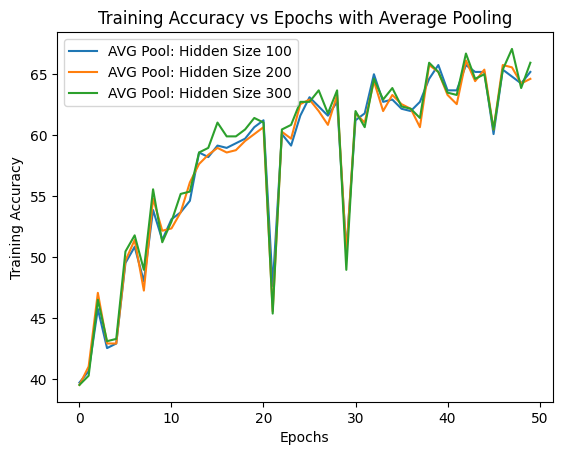

In [25]:

# Itération sur chaque taille de couche cachée et son historique correspondant
for hidden_size, history in history_dict_avg.items():
    # Extraction des valeurs de perte d'entraînement
    training_loss = [epoch_metrics['val_acc'] for epoch_metrics in history]

    # Tracé de la courbe de perte pour cette taille de couche cachée
    plt.plot(training_loss, label=f'AVG Pool: Hidden Size {hidden_size}')

# Ajout de titres et de labels
plt.title('Training Accuracy vs Epochs with Average Pooling')
plt.xlabel('Epochs')
plt.ylabel('Training Accuracy')

# Affichage de la légende
plt.legend()

# Affichage du graphique
plt.show()

On peut remarqué qu'il n'y a pas de différence claire et cohérente qui indiquerait qu'une taille plus grande mène systématiquement à une meilleure exactitude.

#### 5.1.b. Max Pooling

In [26]:
# Dictionnaire pour stocker l'historique de formation pour chaque configuration
history_dict_max = {}

# Entraînez le modèle pour chaque taille cachée avec une mise en commun minimale et stockez l'historique
for hidden_size in hidden_sizes:
    model, trainer, history, test_data = train_model(aggregations['maxpool'], nlp.meta['vectors']['width'], hidden_size, len(target_incident_type), MAX_LEARNING_RATE, f"maxpool_{hidden_size}")
    history_dict_max[hidden_size] = history

Epoch:  1/50 Train steps: 39 Val steps: 9 1m21.51s loss: 1.956382 acc: 30.707071 fscore_macro: 0.099177 val_loss: 1.844114 val_acc: 39.359699 val_fscore_macro: 0.066413
Epoch 1: val_acc improved from -inf to 39.35970, saving file to model/maxpool_embedding_mlp_maxpool_100/checkpoint_epoch_1.ckpt
Epoch:  2/50 Train steps: 39 Val steps: 9 0.15s loss: 1.790653 acc: 35.191919 fscore_macro: 0.112421 val_loss: 1.746405 val_acc: 36.911488 val_fscore_macro: 0.138027
Epoch:  3/50 Train steps: 39 Val steps: 9 0.15s loss: 1.770124 acc: 36.484848 fscore_macro: 0.125542 val_loss: 1.945225 val_acc: 18.079096 val_fscore_macro: 0.059850
Epoch:  4/50 Train steps: 39 Val steps: 9 0.15s loss: 1.724474 acc: 39.232323 fscore_macro: 0.134946 val_loss: 1.671569 val_acc: 41.054614 val_fscore_macro: 0.122706
Epoch 4: val_acc improved from 39.35970 to 41.05461, saving file to model/maxpool_embedding_mlp_maxpool_100/checkpoint_epoch_4.ckpt
Epoch:  5/50 Train steps: 39 Val steps: 9 0.17s loss: 1.694408 acc: 39.75

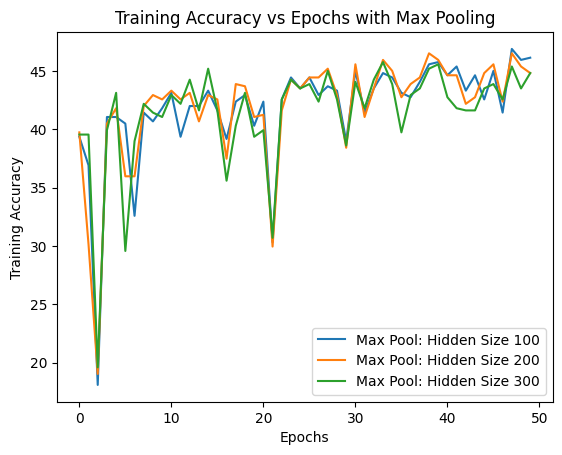

In [27]:
for hidden_size, history in history_dict_max.items():
    training_loss = [epoch_metrics['val_acc'] for epoch_metrics in history]
    plt.plot(training_loss, label=f'Max Pool: Hidden Size {hidden_size}')

plt.title('Training Accuracy vs Epochs with Max Pooling')
plt.xlabel('Epochs')
plt.ylabel('Training Accuracy')
plt.legend()
plt.show()

On peut aussi remarqué ici qu'il n'y a pas de différence claire et cohérente qui indiquerait qu'une taille plus grande mène systématiquement à une meilleure exactitude.

#### 5.1.c. Min Pooling

In [28]:
# Dictionnaire pour stocker l'historique de formation pour chaque configuration
history_dict_min = {}

# Entraînez le modèle pour chaque taille cachée avec une mise en commun minimale et stockez l'historique
for hidden_size in hidden_sizes:
    model, trainer, history, test_data = train_model(aggregations['minpool'], nlp.meta['vectors']['width'], hidden_size, len(target_incident_type), MIN_LEARNING_RATE, f"minpool_{hidden_size}")
    history_dict_min[hidden_size] = history

Epoch:  1/50 Train steps: 39 Val steps: 9 1m26.16s loss: 2.050364 acc: 29.414141 fscore_macro: 0.111343 val_loss: 1.998013 val_acc: 39.736346 val_fscore_macro: 0.066551
Epoch 1: val_acc improved from -inf to 39.73635, saving file to model/minpool_embedding_mlp_minpool_100/checkpoint_epoch_1.ckpt
Epoch:  2/50 Train steps: 39 Val steps: 9 0.15s loss: 1.827658 acc: 33.171717 fscore_macro: 0.118080 val_loss: 1.715877 val_acc: 35.781544 val_fscore_macro: 0.152024
Epoch:  3/50 Train steps: 39 Val steps: 9 0.16s loss: 1.759262 acc: 36.808081 fscore_macro: 0.139260 val_loss: 2.016020 val_acc: 17.890772 val_fscore_macro: 0.073540
Epoch:  4/50 Train steps: 39 Val steps: 9 0.15s loss: 1.706353 acc: 38.262626 fscore_macro: 0.138729 val_loss: 1.659811 val_acc: 40.677966 val_fscore_macro: 0.147782
Epoch 4: val_acc improved from 39.73635 to 40.67797, saving file to model/minpool_embedding_mlp_minpool_100/checkpoint_epoch_4.ckpt
Epoch:  5/50 Train steps: 39 Val steps: 9 0.16s loss: 1.683187 acc: 39.23

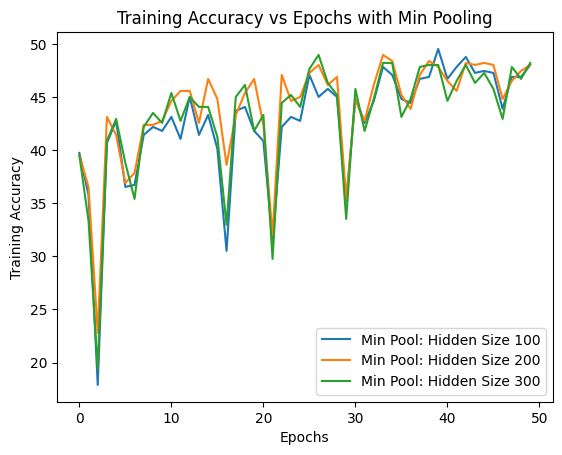

In [29]:
for hidden_size, history in history_dict_min.items():
    training_loss = [epoch_metrics['val_acc'] for epoch_metrics in history]
    plt.plot(training_loss, label=f'Min Pool: Hidden Size {hidden_size}')

plt.title('Training Accuracy vs Epochs with Min Pooling')
plt.xlabel('Epochs')
plt.ylabel('Training Accuracy')
plt.legend()
plt.show()

On peut aussi remarqué de même qu'il n'y a pas de différence claire et cohérente qui indiquerait qu'une taille plus grande mène systématiquement à une meilleure exactitude.

### 5.2 Performances avec le Learning Rate (Taux d'apprentissage)

#### 5.2.a. Average Pooling

In [30]:
history_lr_avg = {}

for learning_rate in learning_rates:
    model, trainer, history, test_data = train_model(aggregation_function=aggregations['avgpool'], embedding_size=nlp.meta['vectors']['width'], hidden_size=HIDDEN_LAYER_SIZE, nb_classes=len(target_incident_type), lr=learning_rate, id=f"avg_lr_{learning_rate}")
    history_lr_avg[learning_rate] = history

Epoch:  1/50 Train steps: 39 Val steps: 9 1m23.40s loss: 2.093949 acc: 12.282828 fscore_macro: 0.070196 val_loss: 2.065118 val_acc: 13.747646 val_fscore_macro: 0.073364
Epoch 1: val_acc improved from -inf to 13.74765, saving file to model/average_embedding_mlp_avg_lr_0.0001/checkpoint_epoch_1.ckpt
Epoch:  2/50 Train steps: 39 Val steps: 9 0.16s loss: 2.039752 acc: 19.838384 fscore_macro: 0.086095 val_loss: 2.014625 val_acc: 27.306968 val_fscore_macro: 0.089474
Epoch 2: val_acc improved from 13.74765 to 27.30697, saving file to model/average_embedding_mlp_avg_lr_0.0001/checkpoint_epoch_2.ckpt
Epoch:  3/50 Train steps: 39 Val steps: 9 0.16s loss: 1.994114 acc: 31.434343 fscore_macro: 0.078972 val_loss: 1.972220 val_acc: 33.898305 val_fscore_macro: 0.078595
Epoch 3: val_acc improved from 27.30697 to 33.89831, saving file to model/average_embedding_mlp_avg_lr_0.0001/checkpoint_epoch_3.ckpt
Epoch:  4/50 Train steps: 39 Val steps: 9 0.15s loss: 1.955927 acc: 36.363636 fscore_macro: 0.069237 

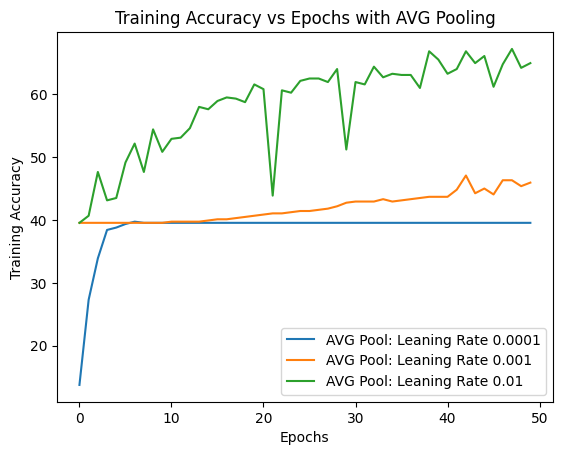

In [31]:
for learning_rate, history in history_lr_avg.items():
    training_loss = [epoch_metrics['val_acc'] for epoch_metrics in history]
    plt.plot(training_loss, label=f'AVG Pool: Leaning Rate {learning_rate}')

plt.title('Training Accuracy vs Epochs with AVG Pooling')
plt.xlabel('Epochs')
plt.ylabel('Training Accuracy')
plt.legend()
plt.show()

L'image montre un graphique de l'exactitude de l'entraînement (Training Accuracy) en fonction des époques (Epochs). Les trois courbes montrent que le taux d'apprentissage a un impact significatif sur l'exactitude de l'entraînement. La courbe verte, avec le taux d'apprentissage le plus élevé, montre une augmentation rapide de l'exactitude, dépassant 60%, on va donc retenir cette valeur comme taux d'apprentissage optimale pour cette fonction.

#### 5.2.b. Max Pooling

In [32]:
history_lr_max = {}

for learning_rate in learning_rates:
    model, trainer, history, test_data = train_model(aggregation_function=aggregations['maxpool'], embedding_size=nlp.meta['vectors']['width'], hidden_size=HIDDEN_LAYER_SIZE, nb_classes=len(target_incident_type), lr=learning_rate, id=f"max_lr_{learning_rate}")
    history_lr_max[learning_rate] = history

Epoch:  1/50 Train steps: 39 Val steps: 9 1m22.61s loss: 2.080548 acc: 34.666667 fscore_macro: 0.094363 val_loss: 1.916220 val_acc: 35.781544 val_fscore_macro: 0.101433
Epoch 1: val_acc improved from -inf to 35.78154, saving file to model/maxpool_embedding_mlp_max_lr_0.0001/checkpoint_epoch_1.ckpt
Epoch:  2/50 Train steps: 39 Val steps: 9 0.15s loss: 1.851848 acc: 35.434343 fscore_macro: 0.092128 val_loss: 1.855898 val_acc: 36.158192 val_fscore_macro: 0.094925
Epoch 2: val_acc improved from 35.78154 to 36.15819, saving file to model/maxpool_embedding_mlp_max_lr_0.0001/checkpoint_epoch_2.ckpt
Epoch:  3/50 Train steps: 39 Val steps: 9 0.15s loss: 1.814159 acc: 36.929293 fscore_macro: 0.094375 val_loss: 1.846144 val_acc: 34.463277 val_fscore_macro: 0.102147
Epoch:  4/50 Train steps: 39 Val steps: 9 0.15s loss: 1.791260 acc: 36.808081 fscore_macro: 0.092939 val_loss: 1.810483 val_acc: 36.723164 val_fscore_macro: 0.099924
Epoch 4: val_acc improved from 36.15819 to 36.72316, saving file to m

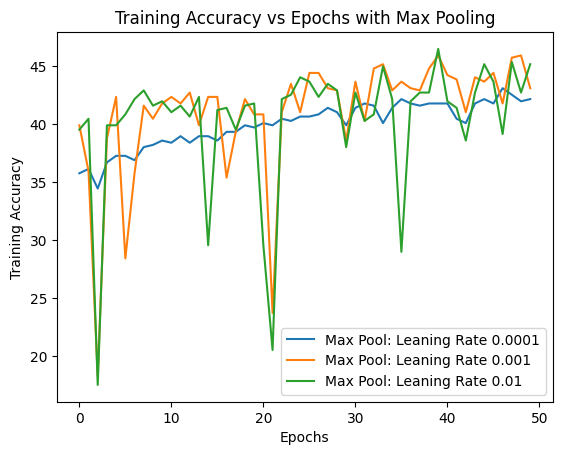

In [33]:
for learning_rate, history in history_lr_max.items():
    training_loss = [epoch_metrics['val_acc'] for epoch_metrics in history]
    plt.plot(training_loss, label=f'Max Pool: Leaning Rate {learning_rate}')

plt.title('Training Accuracy vs Epochs with Max Pooling')
plt.xlabel('Epochs')
plt.ylabel('Training Accuracy')
plt.legend()
plt.show()

Ici, contrairement aux résultats précédents avec AVG Pooling, aucune des courbes ne montre une tendance claire à une meilleure performance avec un taux d'apprentissage particulier. En effet, les trois courbes semblent converger vers une performance similaire vers la fin des 50 époques, toutes se situant entre 35% et 45% d'exactitude. Cependant, si l'on considère la stabilité de l'apprentissage comme un facteur important, le LR = 0.001 pourrait être considéré comme un compromis entre la stabilité et une exactitude raisonnablement élevée. Il permet une croissance plus rapide de l'exactitude sans la variabilité extrême du taux le plus élevé, tout en atteignant une performance similaire à celle du taux le plus bas.

#### 5.2.c. Min Pooling

In [34]:
history_lr_min = {}

for learning_rate in learning_rates:
    model, trainer, history, test_data = train_model(aggregation_function=aggregations['minpool'], embedding_size=nlp.meta['vectors']['width'], hidden_size=HIDDEN_LAYER_SIZE, nb_classes=len(target_incident_type), lr=learning_rate, id=f"min_lr_{learning_rate}")
    history_lr_min[learning_rate] = history

Epoch:  1/50 Train steps: 39 Val steps: 9 1m24.05s loss: 2.419889 acc: 32.848485 fscore_macro: 0.080369 val_loss: 1.810304 val_acc: 40.112994 val_fscore_macro: 0.097608
Epoch 1: val_acc improved from -inf to 40.11299, saving file to model/minpool_embedding_mlp_min_lr_0.0001/checkpoint_epoch_1.ckpt
Epoch:  2/50 Train steps: 39 Val steps: 9 0.16s loss: 1.809506 acc: 36.484848 fscore_macro: 0.082640 val_loss: 1.745795 val_acc: 38.418079 val_fscore_macro: 0.097604
Epoch:  3/50 Train steps: 39 Val steps: 9 0.15s loss: 1.774341 acc: 36.606061 fscore_macro: 0.087046 val_loss: 1.736465 val_acc: 36.723164 val_fscore_macro: 0.099596
Epoch:  4/50 Train steps: 39 Val steps: 9 0.15s loss: 1.755598 acc: 37.171717 fscore_macro: 0.090300 val_loss: 1.717152 val_acc: 37.853107 val_fscore_macro: 0.098228
Epoch:  5/50 Train steps: 39 Val steps: 9 0.15s loss: 1.740029 acc: 36.969697 fscore_macro: 0.092113 val_loss: 1.708593 val_acc: 38.418079 val_fscore_macro: 0.093234
Epoch:  6/50 Train steps: 39 Val step

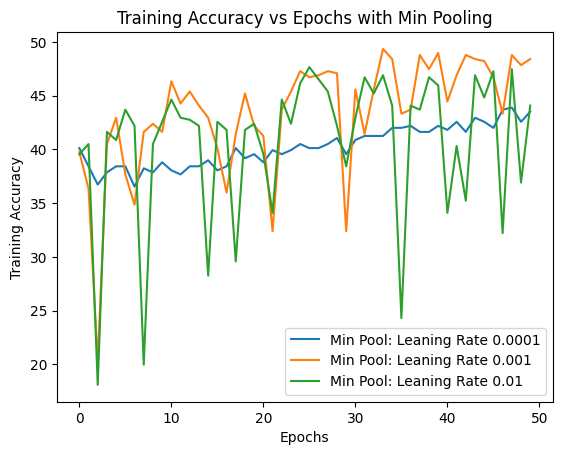

In [35]:
for learning_rate, history in history_lr_min.items():
    training_loss = [epoch_metrics['val_acc'] for epoch_metrics in history]
    plt.plot(training_loss, label=f'Min Pool: Leaning Rate {learning_rate}')

plt.title('Training Accuracy vs Epochs with Min Pooling')
plt.xlabel('Epochs')
plt.ylabel('Training Accuracy')
plt.legend()
plt.show()

Le graphique montre l'exactitude d'entraînement (Training Accuracy) sur plusieurs époques (Epochs) utilisant cette fois la technique de Min Pooling. On compare trois taux d'apprentissage (learning rates, LRs): 0.0001, 0.001, et 0.01. Aucun des LRs ne se démarque comme étant clairement supérieur en termes d'exactitude maximale atteinte. Cependant, le LR de 0.001 semble offrir un bon compromis entre la stabilité et une performance d'exactitude modérée, sans les chutes extrêmes de la courbe avec le LR de 0.01

### 5.1 Entrainement avec des paramètres optimales

In [36]:
BATCH_SIZE = 64
EPOCHS = 100
AVG_LEARNING_RATE = 0.01
MAX_LEARNING_RATE = 0.001
MIN_LEARNING_RATE = 0.001
HIDDEN_LAYER_SIZE = 200

In [49]:
avg_model, avg_trainer, avg_history, avg_test_data = train_model(aggregation_function=aggregations['avgpool'], embedding_size=nlp.meta['vectors']['width'], hidden_size=HIDDEN_LAYER_SIZE, nb_classes=len(target_incident_type), lr=AVG_LEARNING_RATE, id=f"avg")
max_model, max_trainer, max_history, max_test_data = train_model(aggregation_function=aggregations['maxpool'], embedding_size=nlp.meta['vectors']['width'], hidden_size=HIDDEN_LAYER_SIZE, nb_classes=len(target_incident_type), lr=MAX_LEARNING_RATE, id=f"max")
min_model, min_trainer, min_history, min_test_data = train_model(aggregation_function=aggregations['minpool'], embedding_size=nlp.meta['vectors']['width'], hidden_size=HIDDEN_LAYER_SIZE, nb_classes=len(target_incident_type), lr=MIN_LEARNING_RATE, id=f"min")

Epoch:   1/100 Train steps: 39 Val steps: 9 1m23.17s loss: 1.750490 acc: 38.101010 fscore_macro: 0.062450 val_loss: 1.676661 val_acc: 39.548023 val_fscore_macro: 0.062978
Epoch 1: val_acc improved from -inf to 39.54802, saving file to model/average_embedding_mlp_avg/checkpoint_epoch_1.ckpt
Epoch:   2/100 Train steps: 39 Val steps: 9 0.15s loss: 1.655317 acc: 39.272727 fscore_macro: 0.072712 val_loss: 1.612525 val_acc: 41.054614 val_fscore_macro: 0.087105
Epoch 2: val_acc improved from 39.54802 to 41.05461, saving file to model/average_embedding_mlp_avg/checkpoint_epoch_2.ckpt
Epoch:   3/100 Train steps: 39 Val steps: 9 0.16s loss: 1.616263 acc: 40.646465 fscore_macro: 0.094778 val_loss: 1.600448 val_acc: 47.080979 val_fscore_macro: 0.146706
Epoch 3: val_acc improved from 41.05461 to 47.08098, saving file to model/average_embedding_mlp_avg/checkpoint_epoch_3.ckpt
Epoch:   4/100 Train steps: 39 Val steps: 9 0.21s loss: 1.581310 acc: 42.828283 fscore_macro: 0.122646 val_loss: 1.544123 val

## 6. Évaluation et analyse de résultats

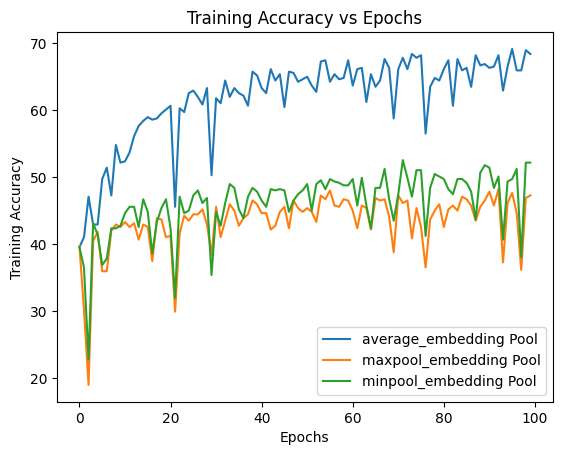

In [50]:
for history, (fn_name, _) in zip([avg_history, max_history, min_history], aggregations.items()):
    training_loss = [epoch_metrics['val_acc'] for epoch_metrics in history]
    plt.plot(training_loss, label=f'{_.__name__} Pool')

plt.title('Training Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Training Accuracy')
plt.legend()
plt.show()

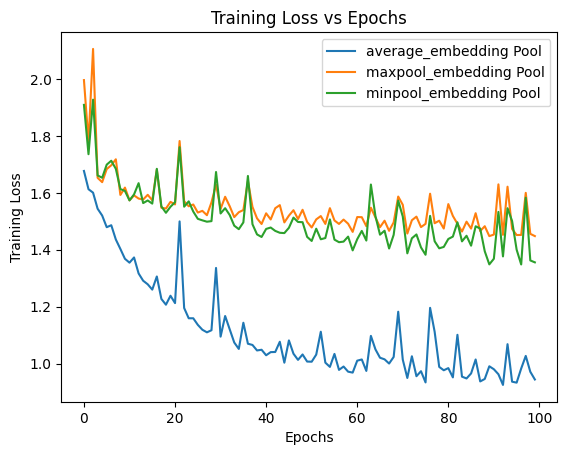

In [51]:
for history, (fn_name, _) in zip([avg_history, max_history, min_history], aggregations.items()):
    training_loss = [epoch_metrics['val_loss'] for epoch_metrics in history]
    plt.plot(training_loss, label=f'{_.__name__} Pool')

plt.title('Training Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.legend()
plt.show()

L'image ci-dessus montre un graphique comparant le Training Accuracy après l'entrainement des trois variantes. Voici ce qu'on peut retenir :

1. **Average Embedding Pool** : La courbe bleue, représentant le modèle avec Average Pooling, montre la meilleure performance en termes d'exactitude d'entraînement. Elle atteint et maintient une valeur élevée, dépassant les 60%, et continue d'augmenter.

2. **Maxpool Embedding Pool** : La courbe orange, correspondant au Max Pooling, présente une exactitude significativement plus basse que celle avec Average Pooling, et montre beaucoup de variabilité dans l'exactitude au fil des époques. Elle dépasse légèrement les 40% et semble plafonner vers la fin du graphique.

3. **Minpool Embedding Pool** : La courbe verte, pour Min Pooling, démontre une performance similaire au modèle avec Max Pooling en termes d'exactitude maximale, mais avec une variabilité légèrement réduite. Elle montre également des signes de plafonnement autour de 40%.

4. **Comparaison des techniques de pooling** : Les résultats montrent clairement que le modèle avec Average Pooling surpasse les variantes avec Max et Min Pooling en termes d'exactitude d'entraînement. Cela peut indiquer que pour la tâche spécifique et les données utilisées, Average Pooling est plus efficace pour capturer les caractéristiques pertinentes des données.

In [52]:
avg_test_history = avg_trainer.test(avg_test_data)
max_test_history = max_trainer.test(max_test_data)
min_test_history = min_trainer.test(min_test_data)

Found best checkpoint at epoch: 96
lr: 0.01, loss: 0.811113, acc: 71.6364, fscore_macro: 0.504937, val_loss: 0.93342, val_acc: 69.1149, val_fscore_macro: 0.473292
Loading checkpoint model/average_embedding_mlp_avg/checkpoint_epoch_96.ckpt
Running test
Test steps: 9 14.28s test_loss: 0.937942 test_acc: 68.926554 test_fscore_macro: 0.474849  
Found best checkpoint at epoch: 93
lr: 0.001, loss: 1.37981, acc: 50.303, fscore_macro: 0.313793, val_loss: 1.45236, val_acc: 48.2109, val_fscore_macro: 0.191278
Loading checkpoint model/maxpool_embedding_mlp_max/checkpoint_epoch_93.ckpt
Running test
Test steps: 9 14.77s test_loss: 1.552125 test_acc: 43.691149 test_fscore_macro: 0.179566  
Found best checkpoint at epoch: 72
lr: 0.001, loss: 1.3346, acc: 51.7172, fscore_macro: 0.262185, val_loss: 1.38736, val_acc: 52.5424, val_fscore_macro: 0.289787
Loading checkpoint model/minpool_embedding_mlp_min/checkpoint_epoch_72.ckpt
Running test
Test steps: 9 14.45s test_loss: 1.454670 test_acc: 47.645951 tes

Voici l'interprétation des résultats précédents de chacun des modèles:

1. **Average Embedding Pool (Average Pooling) avec LR de 0.01** :
   - **Entraînement** : A atteint la meilleure exactitude d'entraînement (acc) à l'époque 96 avec une perte (loss) de 0.811113.
   - **Validation** : A montré une exactitude de validation (val_acc) de 69.1149%, ce qui est relativement élevé.
   - **Test** : Sur l'ensemble de test, le modèle a légèrement sous-performé par rapport à la validation avec une exactitude (test_acc) de 68.926554%. Le F1 score macro (test_fscore_macro) de 0.474849 est modeste, indiquant que la performance du modèle peut varier considérablement entre les différentes classes.

2. **Maxpool Embedding Pool (Max Pooling) avec LR de 0.001** :
   - **Entraînement** : Présente une exactitude d'entraînement inférieure (50.303%) et une perte plus élevée à l'époque 93.
   - **Validation** : A une exactitude de validation de 48.2109%, ce qui indique une performance faible.
   - **Test** : L'exactitude de test (43.691149%) est encore plus basse que l'exactitude de validation, et le F1 score macro (0.179566) est très faible, ce qui suggère une faible performance du modèle, particulièrement dans le contexte de classifications multi-classes où l'équilibre entre précision et rappel est crucial.

3. **Minpool Embedding Pool (Min Pooling) avec LR de 0.001** :
   - **Entraînement** : A une exactitude d'entraînement légèrement supérieure à celle du modèle avec Max Pooling (51.7172%) à l'époque 72.
   - **Validation** : Réalise une meilleure exactitude de validation (52.5424%) par rapport au modèle avec Max Pooling.
   - **Test** : L'exactitude de test (47.645951%) diminue par rapport à la validation, avec un F1 score macro (0.242003) qui reste faible.

Interprétation générale :
- Le modèle avec **Average Pooling et un taux d'apprentissage plus élevé (0.01)** a non seulement le mieux performé pendant l'entraînement et la validation, mais aussi maintenu une performance comparable lors du test. Cela suggère que ce modèle a une meilleure capacité à généraliser par rapport aux modèles avec Max et Min Pooling.
  
- Les modèles avec **Max et Min Pooling** ont montré une performance significativement plus faible à la fois pendant l'entraînement et sur l'ensemble de test. Leur F1 score macro relativement bas sur l'ensemble de test indique une performance particulièrement faible sur certaines classes, ce qui peut être problématique pour des tâches de classification où toutes les classes sont importantes.

- La perte (loss) sur l'ensemble de test pour tous les modèles est légèrement plus élevée que sur l'ensemble de validation, ce qui est attendu, car les modèles sont optimisés pour minimiser la perte sur l'ensemble de validation et non sur l'ensemble de test.

- La diminution de l'exactitude et du F1 score macro du modèle avec **Max Pooling** du set de validation au set de test est particulièrement remarquable et pourrait indiquer un surajustement (overfitting) à l'ensemble de validation.

Ces résultats soulignent l'importance de choisir la bonne architecture et les bons hyperparamètres pour le modèle, car ils ont un impact direct sur la capacité du modèle à apprendre de manière généralisable à partir des données.